## Importacao de Bibliotecas

Carrega as bibliotecas necessarias para o processo de imputacao. O modulo `enable_iterative_imputer` deve ser importado antes do `IterativeImputer` pois este ainda e considerado experimental no scikit-learn. O `RandomForestRegressor` sera utilizado como estimador base do imputador iterativo. As bibliotecas matplotlib e seaborn sao utilizadas para visualizacao dos resultados da avaliacao.

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import sys
import warnings

warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Carregamento do Dataset Tratado

Carrega o dataset tratado e os metadados gerados pelo notebook de tratamento (01_tratamento_dados.ipynb). O arquivo `dados_tratados.pkl` contem o DataFrame com todas as features temporais e codificacao One-Hot das estacoes. O arquivo `metadata_tratamento.pkl` contem informacoes sobre a estrutura do dataset, incluindo os nomes das colunas alvo e features, essenciais para configurar corretamente o processo de imputacao.

In [2]:
df = pd.read_pickle('dados_tratados.pkl')

with open('metadata_tratamento.pkl', 'rb') as f:
    metadata = pickle.load(f)

target_cols = metadata['target_cols']
feature_cols = metadata['feature_cols']
estacao_cols = metadata['estacao_cols']

print(f"Dataset carregado: {df.shape}")
print(f"Total de registros: {len(df):,}")
print(f"Periodo: {metadata['date_range'][0]} ate {metadata['date_range'][1]}")
print(f"Colunas alvo: {target_cols}")
print(f"Total de features: {len(feature_cols)}")

Dataset carregado: (526176, 27)
Total de registros: 526,176
Periodo: 2020-01-01 00:00:00 ate 2024-12-31 23:00:00
Colunas alvo: ['temperatura', 'umidade', 'velocidade_vento']
Total de features: 22


## Preparacao para Avaliacao da Imputacao

Para avaliar a qualidade do metodo de imputacao, uma fracao dos valores conhecidos (nao-nulos) e mascarada artificialmente. Esta tecnica permite comparar os valores imputados com os valores reais apos o processo de imputacao, possibilitando o calculo de metricas de erro como RMSE e MAE.

O procedimento consiste em:
1. Identificar os indices com valores nao-nulos em cada coluna alvo
2. Selecionar aleatoriamente 10% destes indices para mascaramento
3. Armazenar os valores originais antes de substitui-los por NaN
4. Aplicar a mascara (converter para NaN) no DataFrame de trabalho

A semente aleatoria (random_state=42) garante reproducibilidade dos resultados.

In [3]:
np.random.seed(42)
EVALUATION_RATIO = 0.10

df_original = df.copy()
df_masked = df.copy()
masked_data = {}

for col in target_cols:
    non_null_indices = df[col].dropna().index
    n_to_mask = int(len(non_null_indices) * EVALUATION_RATIO)
    mask_indices = np.random.choice(non_null_indices, size=n_to_mask, replace=False)
    
    masked_data[col] = {
        'indices': mask_indices,
        'true_values': df_masked.loc[mask_indices, col].copy()
    }
    
    df_masked.loc[mask_indices, col] = np.nan
    
    total_missing = df_masked[col].isnull().sum()
    print(f"{col}:")
    print(f"  Valores mascarados: {n_to_mask:,}")
    print(f"  Total de valores faltantes apos mascaramento: {total_missing:,}")

temperatura:
  Valores mascarados: 37,905
  Total de valores faltantes apos mascaramento: 185,029
umidade:
  Valores mascarados: 34,248
  Total de valores faltantes apos mascaramento: 217,939
velocidade_vento:
  Valores mascarados: 37,760
  Total de valores faltantes apos mascaramento: 186,332


## Configuracao do IterativeImputer

Configura o imputador iterativo com RandomForestRegressor como estimador base. Os parametros foram escolhidos para balancear qualidade de imputacao e tempo de processamento:

**Parametros do RandomForestRegressor:**
- `n_estimators=50`: Numero de arvores na floresta. Valor moderado para equilibrar precisao e velocidade
- `max_depth=10`: Profundidade maxima das arvores. Limita overfitting e reduz tempo de treinamento
- `min_samples_split=10`: Numero minimo de amostras para dividir um no interno
- `min_samples_leaf=5`: Numero minimo de amostras em cada folha. Evita folhas com poucos exemplos
- `n_jobs=-1`: Utiliza todos os nucleos disponiveis para paralelizacao

**Parametros do IterativeImputer:**
- `max_iter=10`: Numero maximo de iteracoes round-robin. O algoritmo pode convergir antes
- `verbose=2`: Exibe progresso detalhado durante a execucao

In [4]:
rf_estimator = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

imputer = IterativeImputer(
    estimator=rf_estimator,
    max_iter=10,
    random_state=42,
    verbose=2
)

print("Imputador configurado")
print(f"  Estimador: RandomForestRegressor")
print(f"  Iteracoes maximas: 10")
print(f"  Features utilizadas: {len(feature_cols)}")

Imputador configurado
  Estimador: RandomForestRegressor
  Iteracoes maximas: 10
  Features utilizadas: 22


## Execucao da Imputacao nos Dados Mascarados

Executa o processo de imputacao no DataFrame com valores mascarados. O IterativeImputer recebe apenas as colunas necessarias: as tres variaveis alvo (que contem valores faltantes) concatenadas com todas as features (temporais e de estacao). O metodo `fit_transform` ajusta o modelo aos dados e retorna uma matriz com todos os valores faltantes preenchidos.

O resultado e convertido de volta para DataFrame, preservando os indices originais. As colunas `id` e `timestamp` sao adicionadas ao DataFrame resultante para manter a rastreabilidade dos registros.

In [5]:
columns_for_imputation = target_cols + feature_cols
X_masked = df_masked[columns_for_imputation].copy()

print(f"Iniciando imputacao...")
print(f"  Shape dos dados: {X_masked.shape}")
print(f"  Valores faltantes por coluna:")
for col in target_cols:
    missing = X_masked[col].isnull().sum()
    print(f"    {col}: {missing:,}")
print()

X_imputed = imputer.fit_transform(X_masked)

df_imputed = pd.DataFrame(X_imputed, columns=columns_for_imputation, index=df_masked.index)
df_imputed['id'] = df_masked['id']
df_imputed['timestamp'] = df_masked['timestamp']

print(f"\nImputacao concluida")
print(f"  Valores faltantes restantes: {df_imputed[target_cols].isnull().sum().sum()}")

Iniciando imputacao...
  Shape dos dados: (526176, 25)
  Valores faltantes por coluna:
    temperatura: 185,029
    umidade: 217,939
    velocidade_vento: 186,332

[IterativeImputer] Completing matrix with shape (526176, 25)
[IterativeImputer] Completing matrix with shape (526176, 25)
[IterativeImputer] Ending imputation round 1/10, elapsed time 378.73
[IterativeImputer] Change: 58.16526970215839, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 1/10, elapsed time 378.73
[IterativeImputer] Change: 58.16526970215839, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 2/10, elapsed time 776.98
[IterativeImputer] Change: 61.10564930099354, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 2/10, elapsed time 776.98
[IterativeImputer] Change: 61.10564930099354, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1182.29
[IterativeImputer] Change: 56.5084453709848, scaled tolerance: 2.024 
[IterativeImpu

## Avaliacao da Qualidade da Imputacao

Calcula metricas de qualidade comparando os valores imputados com os valores reais que foram mascarados artificialmente. As metricas calculadas sao:

- **RMSE (Root Mean Squared Error)**: Raiz do erro quadratico medio. Penaliza erros grandes mais severamente
- **MAE (Mean Absolute Error)**: Erro absoluto medio. Mais robusto a outliers que o RMSE
- **R-quadrado**: Coeficiente de determinacao. Indica a proporcao da variancia explicada pelo modelo. Valores proximos a 1 indicam boa qualidade

Estas metricas permitem avaliar objetivamente a capacidade do metodo de imputacao em recuperar valores ausentes com base nas informacoes disponveis nas outras variaveis.

In [6]:
print("=" * 70)
print("METRICAS DE QUALIDADE DA IMPUTACAO")
print("=" * 70)

evaluation_results = {}

for col in target_cols:
    indices = masked_data[col]['indices']
    true_values = masked_data[col]['true_values']
    imputed_values = df_imputed.loc[indices, col]
    
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
    mae = mean_absolute_error(true_values, imputed_values)
    r2 = r2_score(true_values, imputed_values)
    
    evaluation_results[col] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'n_samples': len(indices)
    }
    
    print(f"\n{col.upper()}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R-quadrado: {r2:.4f}")
    print(f"  Amostras avaliadas: {len(indices):,}")

print("\n" + "=" * 70)

METRICAS DE QUALIDADE DA IMPUTACAO

TEMPERATURA:
  RMSE: 1.3802
  MAE: 1.0163
  R-quadrado: 0.9020
  Amostras avaliadas: 37,905

UMIDADE:
  RMSE: 6.8695
  MAE: 4.8366
  R-quadrado: 0.9021
  Amostras avaliadas: 34,248

VELOCIDADE_VENTO:
  RMSE: 1.0600
  MAE: 0.8072
  R-quadrado: 0.5006
  Amostras avaliadas: 37,760



## Visualizacao dos Resultados da Avaliacao

Gera graficos de dispersao comparando valores reais versus valores imputados para cada variavel alvo. A linha diagonal vermelha tracejada representa a predicao perfeita (valor imputado igual ao valor real). Quanto mais proximos os pontos estiverem desta linha, melhor a qualidade da imputacao.

O titulo de cada grafico inclui as metricas RMSE e R-quadrado para facilitar a interpretacao visual dos resultados. Os graficos sao salvos em arquivo PNG para documentacao.

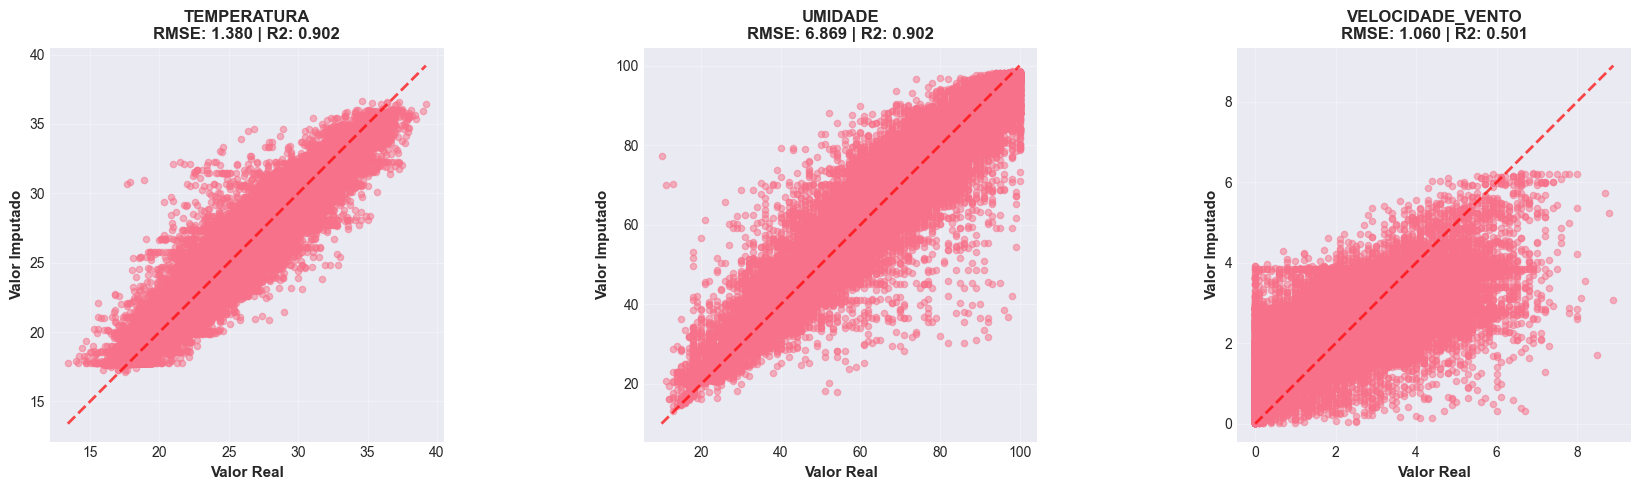

Grafico salvo: avaliacao_imputacao.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(target_cols):
    ax = axes[idx]
    
    indices = masked_data[col]['indices']
    true_values = masked_data[col]['true_values']
    imputed_values = df_imputed.loc[indices, col]
    
    ax.scatter(true_values, imputed_values, alpha=0.5, s=20)
    
    min_val = min(true_values.min(), imputed_values.min())
    max_val = max(true_values.max(), imputed_values.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Valor Real', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor Imputado', fontsize=11, fontweight='bold')
    ax.set_title(
        f"{col.upper()}\nRMSE: {evaluation_results[col]['RMSE']:.3f} | R2: {evaluation_results[col]['R2']:.3f}",
        fontsize=12,
        fontweight='bold'
    )
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('avaliacao_imputacao.png', dpi=150, bbox_inches='tight')
plt.show()

print("Grafico salvo: avaliacao_imputacao.png")

## Imputacao Final nos Dados Originais

Apos validar a qualidade do metodo de imputacao atraves da avaliacao com dados mascarados, executa-se a imputacao nos dados originais. Nesta etapa, apenas os valores genuinamente faltantes (nao mascarados artificialmente) serao preenchidos.

O imputador e re-treinado nos dados originais para garantir que todas as informacoes disponiveis sejam utilizadas no processo. O resultado e um DataFrame completo sem valores faltantes nas variaveis meteorologicas.

In [8]:
print("Imputando valores originalmente faltantes...")

X_original = df_original[columns_for_imputation].copy()

print(f"\nValores faltantes antes da imputacao:")
for col in target_cols:
    missing = X_original[col].isnull().sum()
    pct = (missing / len(X_original) * 100)
    print(f"  {col}: {missing:,} ({pct:.2f}%)")

X_final_imputed = imputer.fit_transform(X_original)

df_final = pd.DataFrame(X_final_imputed, columns=columns_for_imputation, index=df_original.index)
df_final['id'] = df_original['id']
df_final['timestamp'] = df_original['timestamp']

print(f"\nValores faltantes apos imputacao:")
for col in target_cols:
    missing = df_final[col].isnull().sum()
    print(f"  {col}: {missing}")

total_missing = df_final[target_cols].isnull().sum().sum()
if total_missing == 0:
    print(f"\nTodos os valores foram imputados com sucesso")

Imputando valores originalmente faltantes...

Valores faltantes antes da imputacao:
  temperatura: 147,124 (27.96%)
  umidade: 183,691 (34.91%)
  velocidade_vento: 148,572 (28.24%)
[IterativeImputer] Completing matrix with shape (526176, 25)
[IterativeImputer] Completing matrix with shape (526176, 25)
[IterativeImputer] Ending imputation round 1/10, elapsed time 420.47
[IterativeImputer] Change: 60.049466765682865, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 1/10, elapsed time 420.47
[IterativeImputer] Change: 60.049466765682865, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 2/10, elapsed time 845.54
[IterativeImputer] Change: 64.70457678188353, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 2/10, elapsed time 845.54
[IterativeImputer] Change: 64.70457678188353, scaled tolerance: 2.024 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1278.38
[IterativeImputer] Change: 57.88530793585453, scaled tolerance: 2

## Preparacao dos Dados para Atualizacao no Banco

Prepara um DataFrame contendo apenas as colunas necessarias para atualizar a tabela original no banco Neon. A estrutura inclui:
- `id`: Chave primaria para identificar o registro a ser atualizado
- `temperatura`, `umidade`, `velocidade_vento`: Valores imputados

O DataFrame e exportado para CSV como backup e para facilitar inspecao manual dos dados antes da atualizacao no banco.

In [9]:
df_for_update = pd.DataFrame({
    'id': df_final['id'],
    'temperatura': df_final['temperatura'],
    'umidade': df_final['umidade'],
    'velocidade_vento': df_final['velocidade_vento']
})

print("DataFrame preparado para atualizacao no banco")
print(f"  Shape: {df_for_update.shape}")
print(f"\nEstatisticas descritivas dos dados imputados:")
print(df_for_update[['temperatura', 'umidade', 'velocidade_vento']].describe().round(2).to_string())

DataFrame preparado para atualizacao no banco
  Shape: (526176, 4)

Estatisticas descritivas dos dados imputados:
       temperatura    umidade  velocidade_vento
count    526176.00  526176.00         526176.00
mean         25.28      66.79              2.44
std           4.31      21.62              1.36
min          12.50       9.00              0.00
25%          22.02      50.00              1.50
50%          24.70      69.90              2.40
75%          28.59      85.00              3.30
max          39.70     100.00             10.70


## Exportacao dos Resultados

Exporta os resultados da imputacao para arquivos locais:

- `dados_imputados.pkl`: Dataset completo com todas as colunas (incluindo features) em formato pickle
- `dados_para_update_neon.csv`: Apenas as colunas necessarias para atualizacao no banco em formato CSV
- `metricas_imputacao.pkl`: Metricas de avaliacao (RMSE, MAE, R2) serializadas para documentacao

Estes arquivos permitem rastrear os resultados do processo e podem ser utilizados para auditoria ou reprocessamento futuro.

In [10]:
df_final.to_pickle('dados_imputados.pkl')
df_for_update.to_csv('dados_para_update_neon.csv', index=False)

with open('metricas_imputacao.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

print("Arquivos exportados:")
print(f"  - dados_imputados.pkl")
print(f"  - dados_para_update_neon.csv")
print(f"  - metricas_imputacao.pkl")

Arquivos exportados:
  - dados_imputados.pkl
  - dados_para_update_neon.csv
  - metricas_imputacao.pkl


## Atualizacao no Banco Neon (Opcional)

Esta celula executa a atualizacao dos valores imputados diretamente na tabela `dados_meteorologicos` do banco Neon. A operacao e controlada pela variavel `EXECUTAR_UPDATE`:

- `EXECUTAR_UPDATE = False`: A celula apenas exibe uma mensagem informando que a atualizacao esta desabilitada
- `EXECUTAR_UPDATE = True`: Executa o processo de atualizacao em lotes de 1000 registros

O processamento em lotes evita timeouts de conexao e permite monitorar o progresso da atualizacao. Cada registro e atualizado individualmente atraves de uma query UPDATE que tambem atualiza a coluna `updated_at` com o timestamp atual.

**Atencao**: Esta operacao modifica dados no banco de producao. Certifique-se de ter backup antes de executar.

In [11]:
EXECUTAR_UPDATE = False

if EXECUTAR_UPDATE:
    sys.path.insert(0, str(Path('..') / 'fastapi'))
    from services.neon_utils import NeonConnection
    from sqlalchemy import text
    
    env_path = Path('..') / '.env'
    conn = NeonConnection(str(env_path))
    
    print("Atualizando banco Neon...")
    print(f"  Total de registros: {len(df_for_update):,}")
    
    batch_size = 1000
    total_batches = (len(df_for_update) + batch_size - 1) // batch_size
    
    with conn.engine.connect() as connection:
        for i in range(0, len(df_for_update), batch_size):
            batch = df_for_update.iloc[i:i+batch_size]
            batch_num = i // batch_size + 1
            
            for _, row in batch.iterrows():
                query = text("""
                    UPDATE dados_meteorologicos
                    SET 
                        temperatura = :temperatura,
                        umidade = :umidade,
                        velocidade_vento = :velocidade_vento,
                        updated_at = CURRENT_TIMESTAMP
                    WHERE id = :id
                """)
                
                connection.execute(query, {
                    'id': int(row['id']),
                    'temperatura': float(row['temperatura']),
                    'umidade': float(row['umidade']),
                    'velocidade_vento': float(row['velocidade_vento'])
                })
            
            connection.commit()
            print(f"  Batch {batch_num}/{total_batches} concluido")
    
    print(f"\nAtualizacao concluida: {len(df_for_update):,} registros")
else:
    print("Atualizacao no banco desabilitada (EXECUTAR_UPDATE=False)")
    print("Altere para True e execute novamente para atualizar o banco Neon")

Atualizacao no banco desabilitada (EXECUTAR_UPDATE=False)
Altere para True e execute novamente para atualizar o banco Neon


## Resumo do Pipeline de Imputacao

Exibe um resumo consolidado do processo de imputacao, incluindo informacoes do dataset, metodo utilizado, metricas de qualidade e arquivos gerados. Este resumo serve como documentacao final do processo e facilita a reproducibilidade e auditoria dos resultados.

In [12]:
print("=" * 70)
print("RESUMO DO PIPELINE DE IMPUTACAO")
print("=" * 70)

print(f"\nDataset:")
print(f"  Total de registros: {len(df_final):,}")
print(f"  Periodo: {df_final['timestamp'].min()} ate {df_final['timestamp'].max()}")

print(f"\nMetodo de Imputacao:")
print(f"  Algoritmo: IterativeImputer")
print(f"  Estimador: RandomForestRegressor (n_estimators=50, max_depth=10)")
print(f"  Features utilizadas: {len(feature_cols)} (temporais + estacao)")

print(f"\nMetricas de Qualidade (avaliacao em valores mascarados):")
for col, metrics in evaluation_results.items():
    print(f"\n  {col.upper()}:")
    print(f"    RMSE: {metrics['RMSE']:.4f}")
    print(f"    MAE: {metrics['MAE']:.4f}")
    print(f"    R-quadrado: {metrics['R2']:.4f}")

print(f"\nArquivos Gerados:")
print(f"  - dados_imputados.pkl")
print(f"  - dados_para_update_neon.csv")
print(f"  - metricas_imputacao.pkl")
print(f"  - avaliacao_imputacao.png")

print(f"\nPipeline de imputacao concluido com sucesso")
print("=" * 70)

RESUMO DO PIPELINE DE IMPUTACAO

Dataset:
  Total de registros: 526,176
  Periodo: 2020-01-01 00:00:00 ate 2024-12-31 23:00:00

Metodo de Imputacao:
  Algoritmo: IterativeImputer
  Estimador: RandomForestRegressor (n_estimators=50, max_depth=10)
  Features utilizadas: 22 (temporais + estacao)

Metricas de Qualidade (avaliacao em valores mascarados):

  TEMPERATURA:
    RMSE: 1.3802
    MAE: 1.0163
    R-quadrado: 0.9020

  UMIDADE:
    RMSE: 6.8695
    MAE: 4.8366
    R-quadrado: 0.9021

  VELOCIDADE_VENTO:
    RMSE: 1.0600
    MAE: 0.8072
    R-quadrado: 0.5006

Arquivos Gerados:
  - dados_imputados.pkl
  - dados_para_update_neon.csv
  - metricas_imputacao.pkl
  - avaliacao_imputacao.png

Pipeline de imputacao concluido com sucesso
